# Imports

In [1]:
pip install ucimlrepo

In [2]:
from __future__ import annotations

import warnings
from contextlib import contextmanager
from dataclasses import dataclass, field
from enum import Enum, auto
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from collections import Counter
import networkx as nx

from ucimlrepo import fetch_ucirepo
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc,
    matthews_corrcoef, average_precision_score,
    balanced_accuracy_score, make_scorer,
    brier_score_loss, log_loss
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from tqdm.auto import tqdm

# Try to import ConvergenceWarning
try:
    from sklearn.exceptions import ConvergenceWarning
except ImportError:
    ConvergenceWarning = UserWarning


# Configurations

In [ ]:
@dataclass(frozen=True)
class Config:
    """Global configuration settings."""
    RANDOM_STATE: int = 42
    TEST_SIZE: float = 0.2
    INNER_CV: int = 5
    OUTER_CV: int = 5
    N_ITER_RANDOM_SEARCH: int = 20
    N_JOBS: int = -1
    MAX_ITER: int = 5000
    CORRELATION_THRESHOLD: float = 0.99  # Very high to keep almost all features
    VIF_THRESHOLD: float = 10.0
    
    # Feature selection settings
    VARIANCE_THRESHOLD: float = 0.0    # Keep all features regardless of variance
    MAX_FEATURES_RATIO: float = 10.0   # Effectively disable SelectKBest to keep p >> n
    
    # Visualization settings
    FIGURE_DPI: int = 300
    DEFAULT_FIGSIZE: Tuple[int, int] = (12, 8)
    
    # Output paths
    OUTPUT_DIR: Path = Path("outputs")


CONFIG = Config()
CONFIG.OUTPUT_DIR.mkdir(exist_ok=True)

In [4]:
@contextmanager
def suppress_all_warnings():
    """Robustly suppress warnings."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield


In [5]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [6]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': CONFIG.DEFAULT_FIGSIZE,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

np.random.seed(CONFIG.RANDOM_STATE)

# Data Classes

In [7]:
class ModelType(Enum):
    LINEAR = auto()
    NONLINEAR = auto()
    ENSEMBLE = auto()
    NEURAL_NETWORK = auto()


@dataclass
class ModelConfig:
    """Configuration for a single model."""
    name: str
    model: BaseEstimator
    model_type: ModelType
    param_grid: Optional[Dict[str, List]] = None


@dataclass
class EvaluationMetrics:
    """Container for model evaluation metrics."""
    accuracy: float
    auc: float
    precision: float
    recall: float
    f1: float
    mcc: float
    pr_auc: float
    balanced_accuracy: float
    sensitivity: float
    specificity: float
    brier_score: Optional[float] = None
    
    @classmethod
    def from_predictions(
        cls,
        y_true: np.ndarray,
        y_pred: np.ndarray,
        y_proba: Optional[np.ndarray] = None
    ) -> 'EvaluationMetrics':
        """Create metrics from predictions."""
        # Handle edge case: all same predictions
        unique_pred = np.unique(y_pred)
        unique_true = np.unique(y_true)
        
        if len(unique_pred) == 1 or len(unique_true) == 1:
            # Degenerate case
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        else:
            cm = confusion_matrix(y_true, y_pred)
        
        # Safely unpack confusion matrix
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle edge cases
            tn = fp = fn = tp = 0
            if cm.shape[0] >= 1:
                if unique_pred[0] == 0:
                    tn = cm[0, 0] if cm.shape[1] > 0 else 0
                else:
                    tp = cm[0, 0] if cm.shape[1] > 0 else 0
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        
        if y_proba is None:
            y_proba = y_pred.astype(float)
        
        # Clip probabilities to valid range
        y_proba = np.clip(y_proba, 1e-10, 1 - 1e-10)
        
        try:
            auc_score = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc_score = 0.5
        
        try:
            pr_auc_score = average_precision_score(y_true, y_proba)
        except ValueError:
            pr_auc_score = np.mean(y_true)
        
        try:
            brier = brier_score_loss(y_true, y_proba)
        except ValueError:
            brier = None
        
        return cls(
            accuracy=accuracy_score(y_true, y_pred),
            auc=auc_score,
            precision=precision_score(y_true, y_pred, zero_division=0),
            recall=recall_score(y_true, y_pred, zero_division=0),
            f1=f1_score(y_true, y_pred, zero_division=0),
            mcc=matthews_corrcoef(y_true, y_pred),
            pr_auc=pr_auc_score,
            balanced_accuracy=balanced_accuracy_score(y_true, y_pred),
            sensitivity=sensitivity,
            specificity=specificity,
            brier_score=brier
        )
    
    def to_dict(self) -> Dict[str, float]:
        return {k: v for k, v in self.__dict__.items() if v is not None}


@dataclass
class CVResults:
    """Container for cross-validation results."""
    metrics: Dict[str, List[float]] = field(default_factory=lambda: {
        'accuracy': [], 'auc': [], 'f1': [], 'mcc': [], 
        'pr_auc': [], 'bacc': [], 'sensitivity': [], 
        'specificity': [], 'precision': [], 'brier': []
    })
    best_params: List[Dict] = field(default_factory=list)
    feature_importances: List[Optional[np.ndarray]] = field(default_factory=list)
    n_selected_features: List[int] = field(default_factory=list)
    
    def add_fold_metrics(self, metrics: EvaluationMetrics):
        """Add metrics from a single fold."""
        self.metrics['accuracy'].append(metrics.accuracy)
        self.metrics['auc'].append(metrics.auc)
        self.metrics['f1'].append(metrics.f1)
        self.metrics['mcc'].append(metrics.mcc)
        self.metrics['pr_auc'].append(metrics.pr_auc)
        self.metrics['bacc'].append(metrics.balanced_accuracy)
        self.metrics['sensitivity'].append(metrics.sensitivity)
        self.metrics['specificity'].append(metrics.specificity)
        self.metrics['precision'].append(metrics.precision)
        if metrics.brier_score is not None:
            self.metrics['brier'].append(metrics.brier_score)
    
    @property
    def is_empty(self) -> bool:
        return len(self.metrics.get('mcc', [])) == 0
    
    @property
    def n_completed_folds(self) -> int:
        return len(self.metrics.get('mcc', []))
    
    def has_feature_importance(self) -> bool:
        """Check if any feature importances were collected."""
        return any(imp is not None for imp in self.feature_importances)



# Data Loading and Preprocessing

In [8]:
class DataLoader:
    """Handles data loading."""
    
    def __init__(self, dataset_id: int = 728):
        self.dataset_id = dataset_id
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.feature_names: List[str] = []
        
    def load(self) -> Tuple[pd.DataFrame, pd.Series]:
        """Load and preprocess the dataset."""
        logger.info(f"Loading dataset {self.dataset_id}...")
        
        data = fetch_ucirepo(id=self.dataset_id)
        self.X = data.data.features
        y_raw = data.data.targets
        
        # Binary encoding: NonToxic=1, Toxic=0
        self.y = (y_raw['Class'] == 'NonToxic').astype(int)
        self.feature_names = self.X.columns.tolist()
        
        self._print_summary(y_raw)
        return self.X, self.y
    
    def _print_summary(self, y_raw: pd.DataFrame):
        """Print dataset summary."""
        print("=" * 80)
        print("DATASET OVERVIEW")
        print("=" * 80)
        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Number of molecules (n): {self.X.shape[0]}")
        print(f"Number of descriptors (p): {self.X.shape[1]}")
        print(f"Dimensionality ratio (p/n): {self.X.shape[1]/self.X.shape[0]:.2f}")
        print(f"\nℹ HIGH-DIMENSIONAL DATA: p >> n")
        print(f"  Research Focus: Model performance in high-dimensional space.")
        print(f"\nClass distribution:")
        print(y_raw['Class'].value_counts())
        print(f"\nMissing values: {self.X.isnull().sum().sum()}")

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Handles feature selection for high-dimensional data."""
    
    def __init__(
        self,
        variance_threshold: float = CONFIG.VARIANCE_THRESHOLD,
        correlation_threshold: float = CONFIG.CORRELATION_THRESHOLD,
        max_features: Optional[int] = None,
        random_state: int = CONFIG.RANDOM_STATE
    ):
        self.variance_threshold = variance_threshold
        self.correlation_threshold = correlation_threshold
        self.max_features = max_features
        self.random_state = random_state
        
        self.selected_features_: Optional[List[str]] = None
        self.variance_selector_: Optional[VarianceThreshold] = None
    
    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        """Fit feature selection pipeline."""
        if not isinstance(X, pd.DataFrame):
            # Attempt conversion if it's an array but we might lose column names
            # ideally should be DF
            try:
                X = pd.DataFrame(X)
            except:
                pass

        self.n_original_ = X.shape[1]
        
        # Step 1: Remove near-zero variance features
        X_var = self._remove_low_variance(X)
        self.n_after_variance_ = X_var.shape[1]
        
        # Step 2: Remove highly correlated features
        X_uncorr = self._remove_correlated(X_var)
        self.n_after_correlation_ = X_uncorr.shape[1]
        
        # Step 3: Select top features by mutual information
        if self.max_features and X_uncorr.shape[1] > self.max_features:
            X_final = self._select_top_features(X_uncorr, y)
        else:
            X_final = X_uncorr
        
        self.n_final_ = X_final.shape[1]
        self.selected_features_ = X_final.columns.tolist()
        
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Transform new data using fitted selection."""
        if not isinstance(X, pd.DataFrame):
             # Try to convert to DF using range index if strictly necessary, 
             # but keeping column names is critical for this logic. 
             # Assuming input is DataFrame as per pipeline contract in this notebook.
             pass
             
        if self.selected_features_ is None:
            raise ValueError("Must call fit first")
        
        # Only keep features that exist in both
        available = [f for f in self.selected_features_ if f in X.columns]
        
        # If input was array-like converted to DF without columns, this fails.
        # But we will ensure X is DF in CV.
        return X[available]
    
    def fit_transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)
    
    def _remove_low_variance(self, X: pd.DataFrame) -> pd.DataFrame:
        """Remove features with near-zero variance."""
        # Scale first to make variance comparable
        X_values = X.values
        X_mean = X_values.mean(axis=0)
        X_std = X_values.std(axis=0)
        X_scaled = (X_values - X_mean) / (X_std + 1e-10)
        
        self.variance_selector_ = VarianceThreshold(threshold=self.variance_threshold)
        
        with suppress_all_warnings():
            self.variance_selector_.fit(X_scaled)
            mask = self.variance_selector_.get_support()
        
        return X.iloc[:, mask]
    
    def _remove_correlated(self, X: pd.DataFrame) -> pd.DataFrame:
        """Remove highly correlated features, keeping one from each group."""
        corr_matrix = X.corr().abs()
        
        # Get upper triangle
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Find features to drop
        to_drop = set()
        for column in upper.columns:
            # If this column has high correlation with any column not yet dropped
            high_corr = upper[column] > self.correlation_threshold
            if high_corr.any():
                # Check if it's already going to be dropped
                correlated_with = upper.index[high_corr].tolist()
                # Only drop if none of the correlated features are already dropped
                if not any(c in to_drop for c in correlated_with):
                    to_drop.add(column)
        
        return X.drop(columns=list(to_drop))
    
    def _select_top_features(
        self, 
        X: pd.DataFrame, 
        y: pd.Series
    ) -> pd.DataFrame:
        """Select top features by mutual information."""
        if y is None:
            return X
            
        selector = SelectKBest(
            score_func=mutual_info_classif, 
            k=self.max_features
        )
        
        with suppress_all_warnings():
            selector.fit(X, y)
        
        mask = selector.get_support()
        return X.loc[:, mask]

In [ ]:
class DataPreprocessor:
    """Handles train-test splitting."""
    
    def __init__(
        self,
        test_size: float = CONFIG.TEST_SIZE,
        random_state: int = CONFIG.RANDOM_STATE,
        apply_feature_selection: bool = True, # Kept for signature compatibility
        max_features: Optional[int] = None    # Kept for signature compatibility
    ):
        self.test_size = test_size
        self.random_state = random_state
        self.class_weights: Optional[Dict[int, float]] = None
        
    def prepare_data(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        apply_smote: bool = False
    ) -> Dict[str, Any]:
        """Prepare data for modeling (Splitting only)."""
        # Shuffle
        np.random.seed(self.random_state)
        shuffle_idx = np.random.permutation(len(X))
        X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
        y_shuffled = y.iloc[shuffle_idx].reset_index(drop=True)
        
        # Split 
        X_train, X_test, y_train, y_test = train_test_split(
            X_shuffled, y_shuffled,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y_shuffled
        )
        
        # Compute class weights (on training set)
        self._compute_class_weights(y_train)
        
        result = {
            'X_train': X_train, # DataFrame (Raw)
            'X_test': X_test,   # DataFrame (Raw)
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': X.columns.tolist()
        }
        
        if apply_smote:
            smote = SMOTE(random_state=self.random_state)
            # Apply SMOTE on raw data (numerical)
            X_train_smote, y_train_smote = smote.fit_resample(
                X_train, y_train
            )
            result['X_train_smote'] = X_train_smote
            result['y_train_smote'] = y_train_smote
            
        self._print_summary(result)
        return result
    
    def _compute_class_weights(self, y_train: np.ndarray):
        """Compute balanced class weights."""
        weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        self.class_weights = {i: w for i, w in enumerate(weights)}
        
    def _print_summary(self, data: Dict[str, Any]):
        """Print preprocessing summary."""
        print("\n" + "=" * 80)
        print("DATA PREPROCESSING SUMMARY")
        print("=" * 80)
        print(f"Training set: {data['X_train'].shape}")
        print(f"Test set: {data['X_test'].shape}")
        print(f"Features: {len(data['feature_names'])}")
        print(f"\nTraining class distribution:")
        unique, counts = np.unique(data['y_train'], return_counts=True)
        for u, c in zip(unique, counts):
            print(f"  Class {u}: {c} ({c/len(data['y_train'])*100:.1f}%)")
        
        if 'X_train_smote' in data:
            print(f"\nSMOTE training set: {data['X_train_smote'].shape}")
            
        if self.class_weights:
            print(f"\nClass weights: {self.class_weights}")

# Multicollinearity Analysis

In [11]:
class MulticollinearityAnalyzer:
    """Analyzes multicollinearity in feature data."""
    
    def __init__(
        self,
        corr_threshold: float = CONFIG.CORRELATION_THRESHOLD,
        vif_threshold: float = CONFIG.VIF_THRESHOLD
    ):
        self.corr_threshold = corr_threshold
        self.vif_threshold = vif_threshold
        self.results: Dict[str, Any] = {}
        
    def analyze(self, X: pd.DataFrame) -> Dict[str, Any]:
        """Run comprehensive multicollinearity analysis."""
        print("=" * 80)
        print("MULTICOLLINEARITY DIAGNOSTICS")
        print("=" * 80)
        
        corr_matrix = X.corr()
        
        # Eigenvalue analysis
        self._analyze_eigenvalues(corr_matrix)
        
        # Pairwise correlations
        self._analyze_pairwise_correlations(corr_matrix)
        
        # VIF analysis
        self._analyze_vif(corr_matrix)
        
        # Visualization
        self._plot_diagnostics(corr_matrix)
        
        return self.results
    
    def _analyze_eigenvalues(self, corr_matrix: pd.DataFrame):
        """Analyze eigenvalue spectrum."""
        eigenvalues = np.linalg.eigvalsh(corr_matrix)
        condition_number = np.sqrt(
            eigenvalues.max() / (eigenvalues.min() + 1e-10)
        )
        effective_rank = np.sum(eigenvalues > 1e-5)
        
        self.results['eigenvalues'] = eigenvalues
        self.results['condition_number'] = condition_number
        self.results['effective_rank'] = effective_rank
        
        print(f"\n1. GLOBAL STABILITY ANALYSIS")
        print(f"   Condition Number: {condition_number:.2e}")
        print(f"   Effective Rank: {effective_rank}/{len(eigenvalues)}")
        
        if condition_number > 100:
            print("   ⚠ DIAGNOSIS: Severe multicollinearity detected")
    
    def _analyze_pairwise_correlations(self, corr_matrix: pd.DataFrame):
        """Analyze pairwise correlations using graph theory."""
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        high_corr = upper.stack()
        high_corr = high_corr[high_corr.abs() > self.corr_threshold]
        
        # Build correlation graph
        G = nx.Graph()
        for (f1, f2), val in high_corr.items():
            G.add_edge(f1, f2, weight=val)
        
        components = list(nx.connected_components(G))
        
        self.results['high_corr_pairs'] = high_corr
        self.results['correlation_graph'] = G
        self.results['redundant_clusters'] = components
        
        print(f"\n2. PAIRWISE REDUNDANCY (|r| > {self.corr_threshold})")
        print(f"   Correlated pairs: {len(high_corr)}")
        print(f"   Redundant clusters: {len(components)}")
        
        if components:
            largest = max(components, key=len)
            print(f"   Largest cluster size: {len(largest)}")
    
    def _analyze_vif(self, corr_matrix: pd.DataFrame):
        """Calculate Variance Inflation Factors."""
        print(f"\n3. VIF ANALYSIS")
        
        try:
            inv_corr = np.linalg.inv(corr_matrix.values)
            vif_values = np.diag(inv_corr)
        except np.linalg.LinAlgError:
            logger.warning("Singular matrix - using pseudo-inverse")
            inv_corr = np.linalg.pinv(corr_matrix.values)
            vif_values = np.diag(inv_corr)
        
        vif_series = pd.Series(vif_values, index=corr_matrix.index)
        high_vif_count = (vif_series > self.vif_threshold).sum()
        
        self.results['vif'] = vif_series
        
        print(f"   Features with VIF > {self.vif_threshold}: "
              f"{high_vif_count}/{len(vif_series)}")
        print(f"   Mean VIF: {vif_series.mean():.2f}")
        print(f"   Max VIF: {vif_series.max():.2f} ({vif_series.idxmax()})")
    
    def _plot_diagnostics(self, corr_matrix: pd.DataFrame):
        """Create diagnostic visualizations."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Correlation histogram
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        all_corrs = upper.values.flatten()
        all_corrs = all_corrs[~np.isnan(all_corrs)]
        
        axes[0].hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
        axes[0].axvline(self.corr_threshold, color='red', linestyle='--',
                       label=f'Threshold: ±{self.corr_threshold}')
        axes[0].axvline(-self.corr_threshold, color='red', linestyle='--')
        axes[0].set_title('Pairwise Correlation Distribution')
        axes[0].set_xlabel('Correlation Coefficient')
        axes[0].legend()
        
        # Eigenvalue spectrum
        eigenvalues = self.results['eigenvalues']
        axes[1].semilogy(range(len(eigenvalues)), np.sort(eigenvalues)[::-1],
                        'b-', linewidth=2)
        axes[1].axhline(1, color='gray', linestyle='--', alpha=0.5)
        axes[1].set_title('Eigenvalue Spectrum')
        axes[1].set_xlabel('Component Index')
        axes[1].set_ylabel('Eigenvalue (log scale)')
        
        plt.tight_layout()
        plt.savefig(CONFIG.OUTPUT_DIR / 'multicollinearity_analysis.png')
        plt.show()



# Model Registry

In [ ]:
class ModelRegistry:
    """Registry for machine learning models."""
    
    def __init__(self, random_state: int = CONFIG.RANDOM_STATE):
        self.random_state = random_state
        self._models: Dict[str, ModelConfig] = {}
        self._initialize_models()
    
    def _initialize_models(self):
        """Initialize model configurations."""
        rs = self.random_state
        
        # --- LINEAR MODELS ---
        # Logistic Regression with regularization
        for C in [0.01, 0.1, 1.0, 10.0]:
            self._models[f'LR_L2_C{C}'] = ModelConfig(
                name=f'LR_L2_C{C}',
                model=LogisticRegression(
                    penalty='l2', C=C, solver='lbfgs',
                    max_iter=CONFIG.MAX_ITER, random_state=rs
                ),
                model_type=ModelType.LINEAR,
                param_grid={
                    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
                }
            )
        
        # Lasso
        for C in [0.1, 1.0, 10.0]:
            self._models[f'LR_L1_C{C}'] = ModelConfig(
                name=f'LR_L1_C{C}',
                model=LogisticRegression(
                    penalty='l1', C=C, solver='saga',
                    max_iter=CONFIG.MAX_ITER, random_state=rs
                ),
                model_type=ModelType.LINEAR,
                param_grid={
                    'C': [0.01, 0.1, 1.0, 10.0, 100.0]
                }
            )
        
        # Elastic Net
        self._models['LR_ElasticNet'] = ModelConfig(
            name='LR_ElasticNet',
            model=LogisticRegression(
                penalty='elasticnet', solver='saga',
                l1_ratio=0.5, C=1.0, max_iter=CONFIG.MAX_ITER, random_state=rs
            ),
            model_type=ModelType.LINEAR,
            param_grid={
                'C': [0.1, 1.0, 10.0],
                'l1_ratio': [0.3, 0.5, 0.7]
            }
        )
        
        # Weighted LR
        self._models['LR_L2_Weighted'] = ModelConfig(
            name='LR_L2_Weighted',
            model=LogisticRegression(
                penalty='l2', C=1.0, solver='lbfgs',
                class_weight='balanced', max_iter=CONFIG.MAX_ITER, random_state=rs
            ),
            model_type=ModelType.LINEAR,
            param_grid={'C': [0.1, 1.0, 10.0]}
        )
        
        # LDA with regularization
        self._models['LDA'] = ModelConfig(
            name='LDA',
            model=LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
            model_type=ModelType.LINEAR,
            param_grid=None  # No tuning needed with auto shrinkage
        )
        
        # --- TREE-BASED MODELS ---
        for depth in [3, 5, 10]:
            self._models[f'DecisionTree_D{depth}'] = ModelConfig(
                name=f'DecisionTree_D{depth}',
                model=DecisionTreeClassifier(
                    max_depth=depth, min_samples_leaf=5, random_state=rs
                ),
                model_type=ModelType.NONLINEAR,
                param_grid={
                    'max_depth': [3, 5, 7, 10],
                    'min_samples_split': [5, 10, 20],
                    'min_samples_leaf': [3, 5, 10]
                }
            )
        
        # --- ENSEMBLE MODELS ---
        self._models['RandomForest'] = ModelConfig(
            name='RandomForest',
            model=RandomForestClassifier(
                n_estimators=100, max_depth=5,
                min_samples_leaf=5, random_state=rs, n_jobs=-1
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, 10],
                'min_samples_leaf': [3, 5, 10]
            }
        )
        
        self._models['RandomForest_Weighted'] = ModelConfig(
            name='RandomForest_Weighted',
            model=RandomForestClassifier(
                n_estimators=100, max_depth=5,
                min_samples_leaf=5, class_weight='balanced',
                random_state=rs, n_jobs=-1
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 7]
            }
        )
        
        self._models['XGBoost'] = ModelConfig(
            name='XGBoost',
            model=XGBClassifier(
                n_estimators=100, max_depth=3, learning_rate=0.1,
                reg_alpha=1, reg_lambda=1,  # Regularization
                eval_metric='logloss', use_label_encoder=False,
                random_state=rs, verbosity=0
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [2, 3, 5],
                'learning_rate': [0.01, 0.1],
                'reg_alpha': [0.1, 1, 10],
                'reg_lambda': [1, 10]
            }
        )
        
        self._models['GradientBoosting'] = ModelConfig(
            name='GradientBoosting',
            model=GradientBoostingClassifier(
                n_estimators=100, max_depth=3,
                min_samples_leaf=5, random_state=rs
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [2, 3, 5],
                'learning_rate': [0.01, 0.05, 0.1]
            }
        )
        
        # --- SVM ---
        self._models['SVM_Linear'] = ModelConfig(
            name='SVM_Linear',
            model=SVC(
                kernel='linear', C=1.0, probability=True, random_state=rs
            ),
            model_type=ModelType.NONLINEAR,
            param_grid={'C': [0.1, 1.0, 10.0]}
        )
        
        self._models['SVM_RBF'] = ModelConfig(
            name='SVM_RBF',
            model=SVC(
                kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=rs
            ),
            model_type=ModelType.NONLINEAR,
            param_grid={
                'C': [0.1, 1.0, 10.0],
                'gamma': ['scale', 'auto', 0.01, 0.1]
            }
        )
        
        # --- KNN ---
        for k in [3, 5, 7]:
            self._models[f'KNN_K{k}'] = ModelConfig(
                name=f'KNN_K{k}',
                model=KNeighborsClassifier(n_neighbors=k, weights='distance'),
                model_type=ModelType.NONLINEAR,
                param_grid={
                    'n_neighbors': [3, 5, 7, 10],
                    'weights': ['uniform', 'distance']
                }
            )
        
        # --- NEURAL NETWORKS ---
        self._models['NN_Small'] = ModelConfig(
            name='NN_Small',
            model=MLPClassifier(
                hidden_layer_sizes=(20,), max_iter=1000,
                early_stopping=True, validation_fraction=0.15,
                alpha=1.0,  # L2 regularization
                random_state=rs
            ),
            model_type=ModelType.NEURAL_NETWORK,
            param_grid={
                'hidden_layer_sizes': [(10,), (20,), (30,)],
                'alpha': [0.1, 1.0, 10.0]
            }
        )
        
        self._models['NN_Medium'] = ModelConfig(
            name='NN_Medium',
            model=MLPClassifier(
                hidden_layer_sizes=(30, 15), max_iter=1000,
                early_stopping=True, validation_fraction=0.15,
                alpha=1.0, random_state=rs
            ),
            model_type=ModelType.NEURAL_NETWORK,
            param_grid={
                'hidden_layer_sizes': [(20, 10), (30, 15), (50, 25)],
                'alpha': [0.1, 1.0, 10.0]
            }
        )
        
        # --- NAIVE BAYES ---
        self._models['NaiveBayes'] = ModelConfig(
            name='NaiveBayes',
            model=GaussianNB(),
            model_type=ModelType.NONLINEAR,
            param_grid={'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3]}
        )
        
        # --- QDA with regularization ---
        self._models['QDA'] = ModelConfig(
            name='QDA',
            model=QuadraticDiscriminantAnalysis(reg_param=0.5),
            model_type=ModelType.NONLINEAR,
            param_grid={'reg_param': [0.1, 0.3, 0.5, 0.7, 0.9]}
        )
    
    def get_model(self, name: str) -> Optional[ModelConfig]:
        return self._models.get(name)
    
    def get_all_models(self) -> Dict[str, ModelConfig]:
        return self._models.copy()
    
    def get_models_by_type(self, model_type: ModelType) -> Dict[str, ModelConfig]:
        return {
            name: config for name, config in self._models.items()
            if config.model_type == model_type
        }
    
    def __len__(self) -> int:
        return len(self._models)



# Model Evaluation

In [ ]:
class ModelEvaluator:
    """Handles model training and evaluation."""
    
    @staticmethod
    def get_probabilities(model: BaseEstimator, X: np.ndarray) -> np.ndarray:
        """Get probability predictions from model."""
        if hasattr(model, 'predict_proba'):
            return model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X)
            # Normalize to [0, 1]
            range_val = scores.max() - scores.min()
            if range_val > 0:
                return (scores - scores.min()) / range_val
            return np.full_like(scores, 0.5)
        else:
            return model.predict(X).astype(float)
    
    def evaluate(
        self,
        model: BaseEstimator,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
        model_name: str = "Model"
    ) -> Dict[str, Any]:
        """Evaluate a single model."""
        with suppress_all_warnings():
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_proba = self.get_probabilities(model, X_test)
        
        # Training metrics
        y_train_pred = model.predict(X_train)
        y_train_proba = self.get_probabilities(model, X_train)
        
        test_metrics = EvaluationMetrics.from_predictions(y_test, y_pred, y_proba)
        train_metrics = EvaluationMetrics.from_predictions(
            y_train, y_train_pred, y_train_proba
        )
        
        return {
            'model': model_name,
            'train_acc': train_metrics.accuracy,
            'train_auc': train_metrics.auc,
            'test_acc': test_metrics.accuracy,
            'test_auc': test_metrics.auc,
            'precision': test_metrics.precision,
            'recall': test_metrics.recall,
            'f1': test_metrics.f1,
            'mcc': test_metrics.mcc,
            'pr_auc': test_metrics.pr_auc,
            'bacc': test_metrics.balanced_accuracy,
            'sensitivity': test_metrics.sensitivity,
            'specificity': test_metrics.specificity,
            'predicts_one_class': len(np.unique(y_pred)) == 1,
            'confusion_matrix': confusion_matrix(y_test, y_pred, labels=[0, 1])
        }



# Nested Cross-Validation

In [14]:
from sklearn.pipeline import Pipeline

class NestedCrossValidator:
    """Implements nested cross-validation with hyperparameter tuning."""
    
    def __init__(
        self,
        inner_cv: int = CONFIG.INNER_CV,
        outer_cv: int = CONFIG.OUTER_CV,
        n_iter: int = CONFIG.N_ITER_RANDOM_SEARCH,
        scoring: str = 'roc_auc',
        n_jobs: int = CONFIG.N_JOBS,
        random_state: int = CONFIG.RANDOM_STATE
    ):
        self.inner_cv = inner_cv
        self.outer_cv = outer_cv
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.random_state = random_state
    
    def run(
        self,
        model: BaseEstimator,
        X: pd.DataFrame,
        y: pd.Series,
        param_grid: Optional[Dict] = None,
        feature_names: Optional[List[str]] = None,
        verbose: bool = True
    ) -> Optional[Dict[str, Any]]:
        """Run nested cross-validation."""
        # Ensure DFs/Series for indexing
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=feature_names)
        if hasattr(y, 'reset_index'):
            y = y.reset_index(drop=True)
            X = X.reset_index(drop=True)
        else:
            y = pd.Series(y)
            
        dataset_feature_names = feature_names if feature_names else X.columns.tolist()

        outer_cv = StratifiedKFold(
            n_splits=self.outer_cv,
            shuffle=True,
            random_state=self.random_state
        )
        
        cv_results = CVResults()
        
        for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            # Use iloc for DF
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Construct Pipeline
            # Calculate dynamic max_features
            n_samples_fold = len(X_train)
            features_limit = max(10, int(n_samples_fold * CONFIG.MAX_FEATURES_RATIO))
            
            feature_selector = FeatureSelector(
                max_features=features_limit,
                random_state=self.random_state
            )
            
            pipeline = Pipeline([
                ('selector', feature_selector),
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            # Adjust param_grid
            pipeline_params = {}
            if param_grid:
                for k, v in param_grid.items():
                    pipeline_params[f'model__{k}'] = v
            
            try:
                best_model, best_params = self._inner_cv(
                    pipeline, X_train, y_train, pipeline_params, fold_idx
                )
                
                # Evaluate
                y_pred = best_model.predict(X_test)
                y_proba = ModelEvaluator.get_probabilities(best_model, X_test)
                
                # Store results
                metrics = EvaluationMetrics.from_predictions(y_test, y_pred, y_proba)
                cv_results.add_fold_metrics(metrics)
                
                # Clean best_params (remove 'model__' prefix for reporting)
                clean_params = {k.replace('model__', ''): v for k, v in best_params.items()}
                cv_results.best_params.append(clean_params)
                
                # Feature importance
                importance, n_features = self._extract_importance(
                    best_model, dataset_feature_names
                )
                cv_results.feature_importances.append(importance)
                cv_results.n_selected_features.append(int(n_features))
                
            except Exception as e:
                logger.warning(f"Fold {fold_idx} failed: {e}")
                # Print proper traceback for debugging
                import traceback
                traceback.print_exc()
                continue
        
        if cv_results.is_empty:
            return None
        
        return self._compile_results(cv_results, dataset_feature_names)
    
    def _inner_cv(
        self,
        model: BaseEstimator,
        X: pd.DataFrame,
        y: pd.Series,
        param_grid: Optional[Dict],
        fold_idx: int
    ) -> Tuple[BaseEstimator, Dict]:
        """Run inner cross-validation for hyperparameter tuning."""
        should_tune = param_grid is not None and len(param_grid) > 0
        
        if not should_tune:
            fitted_model = clone(model)
            with suppress_all_warnings():
                fitted_model.fit(X, y)
            return fitted_model, {}
        
        inner_cv = StratifiedKFold(
            n_splits=self.inner_cv,
            shuffle=True,
            random_state=self.random_state + fold_idx
        )
        
        # Calculate appropriate n_iter
        n_combinations = 1
        for values in param_grid.values():
            n_combinations *= len(values)
        actual_n_iter = min(self.n_iter, n_combinations)
        
        search = RandomizedSearchCV(
            estimator=clone(model),
            param_distributions=param_grid,
            n_iter=actual_n_iter,
            cv=inner_cv,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            random_state=self.random_state + fold_idx,
            error_score='raise'
        )
        
        with suppress_all_warnings():
            search.fit(X, y)
        
        return search.best_estimator_, dict(search.best_params_)
    
    @staticmethod
    def _extract_importance(
        model: BaseEstimator,
        all_feature_names: List[str]
    ) -> Tuple[Optional[np.ndarray], int]:
        """Extract feature importance from model."""
        # Unwrap pipeline
        if isinstance(model, Pipeline):
            estimator = model.named_steps['model']
            selector = model.named_steps.get('selector')
        else:
            estimator = model
            selector = None

        # Helper to get raw importance
        raw_importance = None
        if hasattr(estimator, 'coef_'):
            raw_importance = np.abs(np.asarray(estimator.coef_).ravel())
            # For multi-class, coef_ might be (n_classes, n_features). Take max or mean?
            # Or assume binary classification here inside one-vs-rest?
            # If 2D, flatten() might be wrong logic.
            if raw_importance.ndim > 1:
                raw_importance = np.mean(raw_importance, axis=0)
        elif hasattr(estimator, 'feature_importances_'):
            raw_importance = np.asarray(estimator.feature_importances_)
            
        if raw_importance is None:
            return None, 0
            
        # Map back if selector exists
        if selector and hasattr(selector, 'selected_features_'):
            selected_names = selector.selected_features_
            
            # If standard scaler is used, it preserves column count so raw_importance corresponds to selected_names
            if len(raw_importance) != len(selected_names):
                # Maybe binary class coef_ is 1D but selected is N?
                # Usually coef_ is (1, n_features) for binary. ravel() handles it.
                return None, 0

            full_importance = np.zeros(len(all_feature_names))
            name_to_idx = {name: i for i, name in enumerate(all_feature_names)}
            
            found_count = 0
            for name, val in zip(selected_names, raw_importance):
                if name in name_to_idx:
                    full_importance[name_to_idx[name]] = val
                    found_count += 1
            
            n_selected = int(np.sum(full_importance > 1e-10))
            return full_importance, n_selected
            
        # Fallback (no selection was done effectively or model was raw)
        n_selected = int(np.sum(raw_importance > 1e-5))
        if len(raw_importance) == len(all_feature_names):
             return raw_importance, n_selected
             
        return None, 0

    def _compile_results(
        self,
        cv_results: CVResults,
        feature_names: Optional[List[str]]
    ) -> Dict[str, Any]:
        """Compile cross-validation results."""
        result = {}
        
        # Calculate statistics for each metric
        for metric_name, values in cv_results.metrics.items():
            if values:
                mean, std, ci = self._calculate_stats(values)
                result[f'mean_{metric_name}'] = mean
                result[f'std_{metric_name}'] = std
                result[f'ci_{metric_name}_lower'] = ci[0]
                result[f'ci_{metric_name}_upper'] = ci[1]
        
        # Feature statistics
        if cv_results.n_selected_features:
            result['mean_n_features'] = float(np.mean(cv_results.n_selected_features))
            result['std_n_features'] = float(np.std(cv_results.n_selected_features))
        
        # Parameter stability
        result['param_stability'] = self._analyze_param_stability(
            cv_results.best_params
        )
        result['all_params'] = cv_results.best_params
        
        # Feature importance - FIXED: use method instead of any()
        if feature_names and cv_results.has_feature_importance():
            result['feature_ranking'] = self._aggregate_importance(
                cv_results.feature_importances, feature_names
            )
        
        result['n_folds_completed'] = cv_results.n_completed_folds
        result['all_scores'] = cv_results.metrics
        
        return result
    
    @staticmethod
    def _calculate_stats(
        values: List[float],
        confidence: float = 0.95
    ) -> Tuple[float, float, Tuple[float, float]]:
        """Calculate mean, std, and confidence interval."""
        n = len(values)
        mean = float(np.mean(values))
        std = float(np.std(values))
        
        if n < 2:
            return mean, std, (mean, mean)
        
        se = stats.sem(values)
        ci = se * stats.t.ppf((1 + confidence) / 2, n - 1)
        return mean, std, (mean - ci, mean + ci)
    
    @staticmethod
    def _analyze_param_stability(params_list: List[Dict]) -> Dict[str, Any]:
        """Analyze parameter stability across folds."""
        if not params_list:
            return {}
        
        # Filter out empty dicts
        non_empty = [p for p in params_list if p]
        if not non_empty:
            return {}
        
        stability = {}
        all_params = set()
        for p in non_empty:
            all_params.update(p.keys())
        
        for param in all_params:
            values = [p.get(param) for p in non_empty if param in p]
            if not values:
                continue
            # Handle unhashable types (lists) by stringifying for counting
            try:
                most_common = Counter(values).most_common(1)[0]
                freq = most_common[1] / len(values)
                val = most_common[0]
            except TypeError:
                # Fallback for unhashable
                pass 
                val = values[0]
                freq = 1.0

            stability[param] = {
                'most_common': val,
                'frequency': freq,
            }
        return stability
    
    @staticmethod
    def _aggregate_importance(
        importances: List[Optional[np.ndarray]],
        feature_names: List[str],
        top_k: int = 20
    ) -> List[Dict]:
        """Aggregate feature importance across folds."""
        valid = [np.asarray(imp) for imp in importances if imp is not None]
        if not valid:
            return []
        
        # Ensure all arrays have the same length (should be ensured by extract_importance)
        min_len = min(len(imp) for imp in valid)
        valid = [imp[:min_len] for imp in valid]
        
        if min_len != len(feature_names):
            feature_names = feature_names[:min_len]
        
        matrix = np.vstack(valid)
        mean_imp = matrix.mean(axis=0)
        std_imp = matrix.std(axis=0)
        
        n_features = min(top_k, len(feature_names))
        
        # Sort indices by mean importance
        indices = np.argsort(mean_imp)[::-1][:n_features]
        
        return [
            {
                'feature': feature_names[i],
                'mean_importance': float(mean_imp[i]),
                'std_importance': float(std_imp[i]),
                'rank': rank + 1
            }
            for rank, i in enumerate(indices)
        ]

# Visualization

In [15]:
class ResultsVisualizer:
    """Handles all visualization tasks."""
    
    def __init__(self, output_dir: Path = CONFIG.OUTPUT_DIR):
        self.output_dir = output_dir
        self.colors = {
            'linear': '#2E86AB',
            'nonlinear': '#A23B72',
            'ensemble': '#F18F01',
            'neural': '#C73E1D',
            'valid': '#2bbbdf',
            'invalid': '#ff6b6b'
        }
    
    def plot_metric_ranking(
        self,
        results_df: pd.DataFrame,
        metric: str = 'mcc',
        n: int = 15,
        title: Optional[str] = None,
        filename: Optional[str] = None
    ) -> plt.Figure:
        """Plot top N models by a specific metric."""
        fig, ax = plt.subplots(figsize=(12, max(6, n * 0.4)))
        
        top_n = results_df.nlargest(n, metric).iloc[::-1]
        
        # Determine colors
        if 'predicts_one_class' in top_n.columns:
            colors = [
                self.colors['invalid'] if row.get('predicts_one_class', False)
                else self.colors['valid']
                for _, row in top_n.iterrows()
            ]
        else:
            colors = self.colors['valid']
        
        bars = ax.barh(range(len(top_n)), top_n[metric], 
                      color=colors, alpha=0.8,
                      edgecolor='black', linewidth=0.5)
        
        ax.set_yticks(range(len(top_n)))
        ax.set_yticklabels(top_n['model'], fontsize=10)
        ax.set_xlabel(metric.upper(), fontsize=12, weight='bold')
        
        if title is None:
            title = f'Top {n} Models by {metric.upper()}'
        ax.set_title(title, fontsize=14, weight='bold')
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, top_n[metric])):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{val:.3f}', va='center', fontsize=9)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(self.output_dir / filename, dpi=CONFIG.FIGURE_DPI, 
                       bbox_inches='tight')
        
        return fig
    
    def plot_cv_results_with_ci(
        self,
        results_df: pd.DataFrame,
        n: int = 10,
        filename: str = 'cv_results_with_ci.png'
    ) -> plt.Figure:
        """Plot CV results with confidence intervals."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        top_n = results_df.nlargest(n, 'mean_mcc')
        y_pos = np.arange(len(top_n))
        
        metrics_config = [
            ('mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper', 'MCC'),
            ('mean_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper', 'PR-AUC'),
            ('mean_bacc', 'ci_bacc_lower', 'ci_bacc_upper', 'Balanced Accuracy')
        ]
        
        colors = self.colors['valid']
        
        for ax, (mean_col, low_col, high_col, label) in zip(axes, metrics_config):
            if mean_col not in top_n.columns:
                continue
                
            ax.barh(y_pos, top_n[mean_col], color=colors, alpha=0.8)
            
            if low_col in top_n.columns and high_col in top_n.columns:
                ax.errorbar(
                    top_n[mean_col], y_pos,
                    xerr=[
                        top_n[mean_col] - top_n[low_col],
                        top_n[high_col] - top_n[mean_col]
                    ],
                    fmt='none', color='black', capsize=4, linewidth=1.5
                )
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_n['model'])
            ax.set_xlabel(label, fontsize=11)
            ax.set_title(f'{label} (Top {n})', fontsize=12, weight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            if 'mcc' in mean_col.lower():
                ax.axvline(0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename, dpi=CONFIG.FIGURE_DPI)
        
        return fig
    
    def plot_train_test_comparison(
        self,
        results_df: pd.DataFrame,
        filename: str = 'train_test_scatter.png'
    ) -> plt.Figure:
        """Plot training vs test accuracy scatter."""
        df = results_df.copy()
        df['overfitting_gap'] = df['train_acc'] - df['test_acc']
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        scatter = ax.scatter(
            df['train_acc'], df['test_acc'],
            c=df['overfitting_gap'], s=100, alpha=0.7,
            cmap='RdYlGn_r', edgecolors='black', linewidth=0.5
        )
        plt.colorbar(scatter, label='Overfitting Gap', ax=ax)
        
        # Reference line
        ax.plot([0.5, 1], [0.5, 1], 'k--', linewidth=2, alpha=0.5,
                label='Perfect Generalization')
        
        # Annotate worst overfitters
        worst = df.nlargest(3, 'overfitting_gap')
        for _, row in worst.iterrows():
            ax.annotate(
                row['model'][:15],
                (row['train_acc'], row['test_acc']),
                xytext=(5, 5), textcoords='offset points', fontsize=8
            )
        
        ax.set_xlabel('Training Accuracy', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title('Model Generalization Analysis', fontsize=14, weight='bold')
        ax.legend(loc='lower right')
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename, dpi=CONFIG.FIGURE_DPI)
        
        return fig


# Main Pipeline

In [16]:
class ToxicityPipeline:
    """Main pipeline orchestrating the entire analysis."""
    
    def __init__(
        self,
        config: Config = CONFIG,
        apply_feature_selection: bool = True
    ):
        self.config = config
        self.apply_feature_selection = apply_feature_selection
        
        self.data_loader = DataLoader()
        self.preprocessor: Optional[DataPreprocessor] = None
        self.model_registry = ModelRegistry(random_state=config.RANDOM_STATE)
        self.evaluator = ModelEvaluator()
        self.cv_validator = NestedCrossValidator(
            inner_cv=config.INNER_CV,
            outer_cv=config.OUTER_CV,
            n_iter=config.N_ITER_RANDOM_SEARCH,
            scoring='roc_auc', # scoring was missing locally in class? defaulted to roc_auc in NestedCV init
            random_state=config.RANDOM_STATE
        )
        self.visualizer = ResultsVisualizer(config.OUTPUT_DIR)
        self.multicollinearity_analyzer = MulticollinearityAnalyzer(
            corr_threshold=config.CORRELATION_THRESHOLD,
            vif_threshold=config.VIF_THRESHOLD
        )
        
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.data: Optional[Dict[str, Any]] = None
        self.results: Dict[str, Any] = {}
    
    def load_data(self) -> 'ToxicityPipeline':
        """Load the dataset."""
        self.X, self.y = self.data_loader.load()
        return self
    
    def preprocess(self, apply_smote: bool = True) -> 'ToxicityPipeline':
        """Split the data."""
        self.preprocessor = DataPreprocessor(
            test_size=self.config.TEST_SIZE,
            random_state=self.config.RANDOM_STATE
        )
        
        self.data = self.preprocessor.prepare_data(
            self.X, self.y, apply_smote=apply_smote
        )
        return self

    def run_multicollinearity_analysis(self, X: Optional[pd.DataFrame] = None) -> Dict[str, Any]:
        """Run multicollinearity diagnostics."""
        if X is None:
            if self.X is not None:
                X = self.X
                print("\nRunning diagnostics on FULL dataset...")
            elif self.data is not None:
                X = self.data['X_train']
                print("\nRunning diagnostics on RAW TRAINING set...")
            else:
                raise ValueError("Must call load_data() or preprocess() first")
        
        self.results['multicollinearity'] = self.multicollinearity_analyzer.analyze(X)
        return self.results['multicollinearity']
    
    def run_baseline_evaluation(
        self,
        use_smote: bool = False,
        verbose: bool = True
    ) -> pd.DataFrame:
        """Run baseline evaluation on all models (using Pipeline on single split)."""
        if self.data is None:
            raise ValueError("Must call preprocess() first")
        
        X_train = self.data['X_train_smote'] if use_smote else self.data['X_train']
        y_train = self.data['y_train_smote'] if use_smote else self.data['y_train']
        X_test = self.data['X_test']
        y_test = self.data['y_test']
        
        suffix = '_SMOTE' if use_smote else ''
        print(f"\n{'='*80}")
        print(f"BASELINE EVALUATION{suffix}")
        print(f"{'='*80}")
        
        # Prepare pipeline for baseline
        n_samples = len(X_train)
        max_features = max(10, int(n_samples * CONFIG.MAX_FEATURES_RATIO))
        
        # Note: We fit selection/scaling on X_train, then transform X_test.
        # This emulates a proper training process on the hold-out set.
        feature_selector = FeatureSelector(
            max_features=max_features,
            random_state=self.config.RANDOM_STATE
        )
        scaler = StandardScaler()
        
        # Fit Transform Train
        # Note: FeatureSelector expects DF. StandardScaler returns Array.
        X_train_prep = feature_selector.fit(X_train, y_train).transform(X_train)
        X_train_prep = scaler.fit_transform(X_train_prep)
        
        # Transform Test
        X_test_prep = feature_selector.transform(X_test)
        X_test_prep = scaler.transform(X_test_prep)
        
        results = []
        models = self.model_registry.get_all_models()
        
        for name, config in tqdm(models.items(), desc=f"Training{suffix}", 
                                 disable=not verbose):
            try:
                with suppress_all_warnings():
                    # Evaluate on preprocessed data
                    metrics = self.evaluator.evaluate(
                        clone(config.model),
                        X_train_prep, X_test_prep,
                        y_train, y_test,
                        f"{name}{suffix}"
                    )
                metrics['model_type'] = config.model_type.name
                results.append(metrics)
                
                if verbose:
                    flag = " ⚠" if metrics['predicts_one_class'] else ""
                    print(f"  {name}: MCC={metrics['mcc']:.4f}, "
                          f"AUC={metrics['test_auc']:.4f}{flag}")
                    
            except Exception as e:
                logger.error(f"Model {name} failed: {e}")
                if verbose:
                    print(f"  {name}: FAILED - {str(e)[:50]}")
        
        results_df = pd.DataFrame(results).sort_values(
            'mcc', ascending=False
        ).reset_index(drop=True)
        
        key = 'baseline_smote' if use_smote else 'baseline'
        self.results[key] = results_df
        
        return results_df
    
    def run_nested_cv(
        self,
        model_names: Optional[List[str]] = None,
        verbose: bool = True
    ) -> pd.DataFrame:
        """Run nested cross-validation on selected models."""
        if self.data is None:
            raise ValueError("Must call preprocess() first")
        
        if model_names is None:
            # Select top performers from baseline if available? 
            # Or just all. The user usually calls with specific list or uses all.
            model_names = list(self.model_registry.get_all_models().keys())
        
        print("\n" + "=" * 80)
        print("NESTED CROSS-VALIDATION (With encapsulated preprocessing)")
        print("=" * 80)
        
        results = []
        feature_names = self.data.get('feature_names', [])
        
        # Use raw training data for CV
        # CV handles splitting, selection, scaling internally for each fold.
        X_cv = self.data['X_train']
        y_cv = self.data['y_train']
        
        for name in tqdm(model_names, desc="Nested CV", disable=not verbose):
            config = self.model_registry.get_model(name)
            if config is None:
                continue
            
            try:
                cv_result = self.cv_validator.run(
                    model=config.model,
                    X=X_cv,
                    y=y_cv,
                    param_grid=config.param_grid,
                    feature_names=feature_names,
                    verbose=False
                )
                
                if cv_result:
                    cv_result['model'] = name
                    cv_result['model_type'] = config.model_type.name
                    results.append(cv_result)
                    
                    if verbose:
                        mcc = cv_result['mean_mcc']
                        ci_low = cv_result['ci_mcc_lower']
                        ci_high = cv_result['ci_mcc_upper']
                        print(f"  {name}: MCC={mcc:.3f} [{ci_low:.3f}, {ci_high:.3f}]")
                else:
                    if verbose:
                        print(f"  {name}: No results (all folds failed)")
                        
            except Exception as e:
                logger.error(f"Nested CV for {name} failed: {e}")
                import traceback
                traceback.print_exc()
                if verbose:
                    print(f"  {name}: FAILED - {str(e)[:50]}")
        
        if not results:
            logger.warning("No nested CV results obtained")
            return pd.DataFrame()
        
        results_df = pd.DataFrame(results).sort_values(
            'mean_mcc', ascending=False
        ).reset_index(drop=True)
        
        self.results['nested_cv'] = results_df
        
        return results_df
    
    # ... generate_visualizations, export_results, print_summary ...
    # (These remain the same or just reference self.results)
    def generate_visualizations(self):
        """Generate all visualizations."""
        print("\n" + "=" * 80)
        print("GENERATING VISUALIZATIONS")
        print("=" * 80)
        
        if 'baseline' in self.results:
            print("\n📊 Plotting Baseline Results (No SMOTE)...")
            df = self.results['baseline']
            self.visualizer.plot_metric_ranking(
                df, metric='mcc', n=15,
                filename='baseline_mcc_ranking.png',
                title='Baseline Model Ranking (MCC)'
            )
            plt.show()
            
            self.visualizer.plot_train_test_comparison(
                df, filename='baseline_train_test.png'
            )
            plt.show()

        if 'baseline_smote' in self.results:
            print("\n📊 Plotting Baseline Results (With SMOTE)...")
            df = self.results['baseline_smote']
            self.visualizer.plot_metric_ranking(
                df, metric='mcc', n=15,
                filename='smote_mcc_ranking.png',
                title='SMOTE Baseline Model Ranking (MCC)'
            )
            plt.show()
            
            self.visualizer.plot_train_test_comparison(
                df, filename='smote_train_test.png'
            )
            plt.show()
        
        if 'nested_cv' in self.results:
            print("\n📊 Plotting Nested Cross-Validation Results...")
            df = self.results['nested_cv']
            self.visualizer.plot_cv_results_with_ci(
                df, n=10, filename='nested_cv_results.png'
            )
            plt.show()
        
        print(f"\n✓ All visualizations saved to {self.config.OUTPUT_DIR}")
    
    def export_results(self):
        """Export all results to CSV files."""
        for key, data in self.results.items():
            if isinstance(data, pd.DataFrame):
                filepath = self.config.OUTPUT_DIR / f'{key}_results.csv'
                data.to_csv(filepath, index=False)
                print(f"✓ Saved: {filepath}")
    
    def print_summary(self):
        """Print analysis summary."""
        print("\n" + "=" * 80)
        print("ANALYSIS SUMMARY")
        print("=" * 80)
        
        if 'nested_cv' in self.results and len(self.results['nested_cv']) > 0:
            df = self.results['nested_cv']
            best = df.iloc[0]
            
            print(f"\n🏆 Best Model: {best['model']}")
            print(f"   MCC: {best['mean_mcc']:.3f} "
                  f"[{best['ci_mcc_lower']:.3f}, {best['ci_mcc_upper']:.3f}]")
            print(f"   PR-AUC: {best['mean_pr_auc']:.3f}")
            print(f"   Balanced Accuracy: {best['mean_bacc']:.3f}")
            
            print("\n📊 Top 5 Models:")
            print(df[['model', 'mean_mcc', 'mean_pr_auc', 'mean_bacc']].head().to_string())

# Execution

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

ℹ HIGH-DIMENSIONAL DATA: p >> n
  Research Focus: Model performance in high-dimensional space.

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Missing values: 0

Running diagnostics on FULL dataset...
MULTICOLLINEARITY DIAGNOSTICS

1. GLOBAL STABILITY ANALYSIS
   Condition Number: 1.54e+06
   Effective Rank: 170/1203
   ⚠ DIAGNOSIS: Severe multicollinearity detected

2. PAIRWISE REDUNDANCY (|r| > 0.99)
   Correlated pairs: 681
   Redundant clusters: 171
   Largest cluster size: 16

3. VIF ANALYSIS
   Features with VIF > 10.0: 613/1203
   Mean VIF: -12332338171494188375985109793319103234048.00
   Max VIF: 4755667454624034510111506432.00 (nF8HeteroRing)


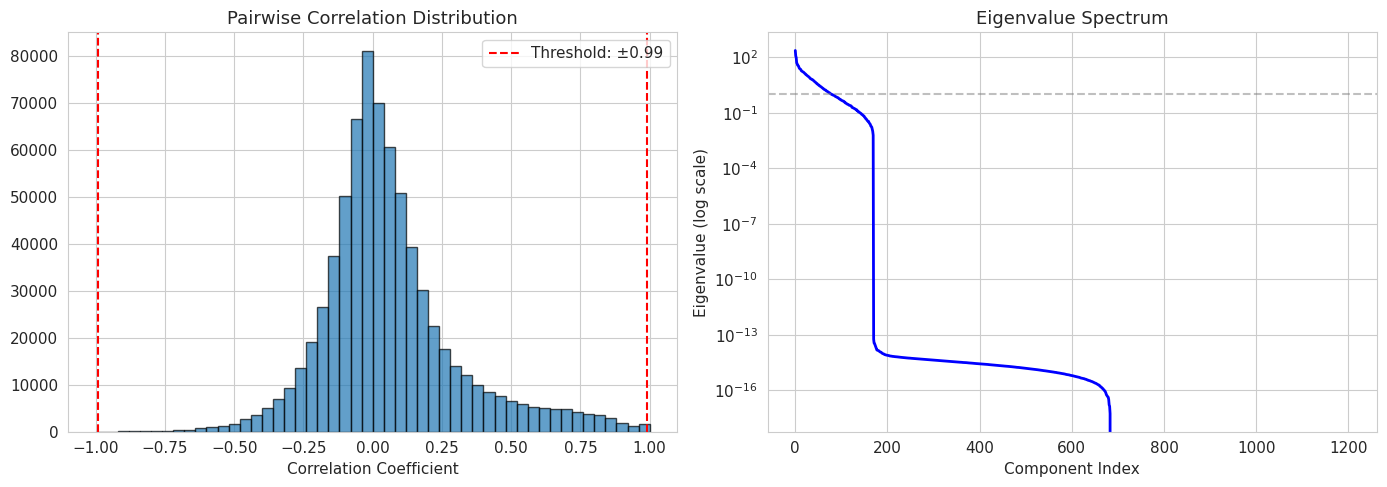


DATA PREPROCESSING SUMMARY
Training set: (136, 1203)
Test set: (35, 1203)
Features: 1203

Training class distribution:
  Class 0: 45 (33.1%)
  Class 1: 91 (66.9%)

SMOTE training set: (182, 1203)

Class weights: {0: np.float64(1.511111111111111), 1: np.float64(0.7472527472527473)}


In [17]:
# Initialize and run pipeline
# We keep apply_feature_selection=True but use extremely permissive settings in Config
# (CORRELATION_THRESHOLD=0.99, VARIANCE_THRESHOLD=0.0, MAX_FEATURES_RATIO=10.0)
# to maintain high dimensionality (p >> n) for thesis research.
pipeline = ToxicityPipeline(apply_feature_selection=True)

# 1. Load data
pipeline.load_data()

# 2. Run multicollinearity diagnostics BEFORE feature selection
# This analyzes the full feature set (p=1203)
pipeline.run_multicollinearity_analysis()

# 3. Preprocess (includes permissive feature selection)
pipeline.preprocess(apply_smote=True)

In [18]:
# Baseline evaluation (no SMOTE)
baseline_results = pipeline.run_baseline_evaluation(use_smote=False, verbose=True)
print("\n📊 Top 10 Models (Baseline):")
print(baseline_results[['model', 'mcc', 'pr_auc', 'bacc', 'test_auc']].head(10).to_string())


BASELINE EVALUATION


Training:   0%|          | 0/26 [00:00<?, ?it/s]

  LR_L2_C0.01: MCC=0.0187, AUC=0.5833
  LR_L2_C0.1: MCC=-0.0195, AUC=0.5758
  LR_L2_C1.0: MCC=0.0296, AUC=0.5568
  LR_L2_C10.0: MCC=-0.0606, AUC=0.5606
  LR_L1_C0.1: MCC=0.0000, AUC=0.5644 ⚠
  LR_L1_C1.0: MCC=0.0720, AUC=0.5530
  LR_L1_C10.0: MCC=0.0296, AUC=0.5417
  LR_ElasticNet: MCC=0.0720, AUC=0.5492
  LR_L2_Weighted: MCC=0.0296, AUC=0.5568
  LDA: MCC=-0.0195, AUC=0.5530
  DecisionTree_D3: MCC=0.4523, AUC=0.7841
  DecisionTree_D5: MCC=0.4523, AUC=0.7424
  DecisionTree_D10: MCC=0.4086, AUC=0.6780
  RandomForest: MCC=0.0126, AUC=0.5341
  RandomForest_Weighted: MCC=0.1168, AUC=0.6098
  XGBoost: MCC=-0.1167, AUC=0.6098
  GradientBoosting: MCC=0.1165, AUC=0.6553
  SVM_Linear: MCC=-0.1000, AUC=0.4394
  SVM_RBF: MCC=0.0000, AUC=0.3750 ⚠
  KNN_K3: MCC=0.0720, AUC=0.6591
  KNN_K5: MCC=0.1820, AUC=0.7348
  KNN_K7: MCC=0.2770, AUC=0.6894
  NN_Small: MCC=-0.0497, AUC=0.5985
  NN_Medium: MCC=-0.1667, AUC=0.5152
  NaiveBayes: MCC=0.0754, AUC=0.5341
  QDA: MCC=0.0000, AUC=0.5758 ⚠

📊 Top 10 Model

In [19]:
# Baseline with SMOTE
smote_results = pipeline.run_baseline_evaluation(use_smote=True, verbose=True)
print("\n📊 Top 10 Models (SMOTE):")
print(smote_results[['model', 'mcc', 'pr_auc', 'bacc', 'test_auc']].head(10).to_string())


BASELINE EVALUATION_SMOTE


Training_SMOTE:   0%|          | 0/26 [00:00<?, ?it/s]

  LR_L2_C0.01: MCC=0.0296, AUC=0.5227
  LR_L2_C0.1: MCC=-0.0195, AUC=0.5644
  LR_L2_C1.0: MCC=-0.0606, AUC=0.5530
  LR_L2_C10.0: MCC=0.0296, AUC=0.5379
  LR_L1_C0.1: MCC=-0.0035, AUC=0.5038
  LR_L1_C1.0: MCC=0.1168, AUC=0.5606
  LR_L1_C10.0: MCC=0.0296, AUC=0.5417
  LR_ElasticNet: MCC=0.0720, AUC=0.5265
  LR_L2_Weighted: MCC=-0.0606, AUC=0.5530
  LDA: MCC=-0.0195, AUC=0.5530
  DecisionTree_D3: MCC=0.0109, AUC=0.4375
  DecisionTree_D5: MCC=0.1599, AUC=0.5777
  DecisionTree_D10: MCC=0.1599, AUC=0.5966
  RandomForest: MCC=0.1165, AUC=0.6742
  RandomForest_Weighted: MCC=0.1165, AUC=0.6742
  XGBoost: MCC=0.1599, AUC=0.5947
  GradientBoosting: MCC=0.2010, AUC=0.6705
  SVM_Linear: MCC=-0.0109, AUC=0.5398
  SVM_RBF: MCC=-0.0035, AUC=0.5833
  KNN_K3: MCC=0.2132, AUC=0.6515
  KNN_K5: MCC=0.1557, AUC=0.6629
  KNN_K7: MCC=0.1167, AUC=0.6591
  NN_Small: MCC=0.1165, AUC=0.5682
  NN_Medium: MCC=0.0296, AUC=0.5871
  NaiveBayes: MCC=-0.1168, AUC=0.4432
  QDA: MCC=-0.0712, AUC=0.3864

📊 Top 10 Models (S

In [20]:
# Select top performers for nested CV
top_baseline = baseline_results.nlargest(8, 'mcc')['model'].tolist()
top_smote = smote_results.nlargest(5, 'mcc')['model'].tolist()

# Add key models we want to evaluate
key_models = ['LR_L2_C1.0', 'LR_L1_C1.0', 'LR_ElasticNet', 'LR_L2_Weighted',
              'RandomForest', 'XGBoost', 'SVM_RBF', 'LDA']
models_for_cv = list(set(top_baseline + top_smote + key_models))

print(f"\n🔬 Running Nested CV on {len(models_for_cv)} models...")


🔬 Running Nested CV on 21 models...


In [21]:
# Nested CV
nested_cv_results = pipeline.run_nested_cv(model_names=models_for_cv, verbose=True)


NESTED CROSS-VALIDATION (With encapsulated preprocessing)


Nested CV:   0%|          | 0/21 [00:00<?, ?it/s]

  NaiveBayes: MCC=-0.028 [-0.346, 0.289]
  LR_L2_C1.0: MCC=-0.205 [-0.488, 0.079]
  LDA: MCC=-0.227 [-0.631, 0.177]
  LR_ElasticNet: MCC=-0.182 [-0.473, 0.109]
  LR_L2_Weighted: MCC=-0.176 [-0.611, 0.259]
  KNN_K7: MCC=-0.134 [-0.210, -0.058]
  SVM_RBF: MCC=-0.015 [-0.056, 0.026]
  RandomForest: MCC=-0.086 [-0.249, 0.077]
  DecisionTree_D10: MCC=-0.128 [-0.481, 0.225]
  GradientBoosting: MCC=0.043 [-0.038, 0.124]
  KNN_K5: MCC=-0.134 [-0.210, -0.058]
  RandomForest_Weighted: MCC=-0.048 [-0.226, 0.129]
  DecisionTree_D3: MCC=-0.128 [-0.481, 0.225]
  XGBoost: MCC=0.075 [-0.075, 0.226]
  DecisionTree_D5: MCC=-0.128 [-0.481, 0.225]
  LR_L1_C1.0: MCC=-0.076 [-0.287, 0.135]



ANALYSIS SUMMARY

🏆 Best Model: XGBoost
   MCC: 0.075 [-0.075, 0.226]
   PR-AUC: 0.688
   Balanced Accuracy: 0.517

📊 Top 5 Models:
                   model  mean_mcc  mean_pr_auc  mean_bacc
0                XGBoost  0.075470     0.687585   0.516667
1       GradientBoosting  0.042972     0.616168   0.516667
2                SVM_RBF -0.014744     0.747166   0.494444
3             NaiveBayes -0.028470     0.671151   0.481287
4  RandomForest_Weighted -0.048430     0.710704   0.479240

GENERATING VISUALIZATIONS

📊 Plotting Baseline Results (No SMOTE)...


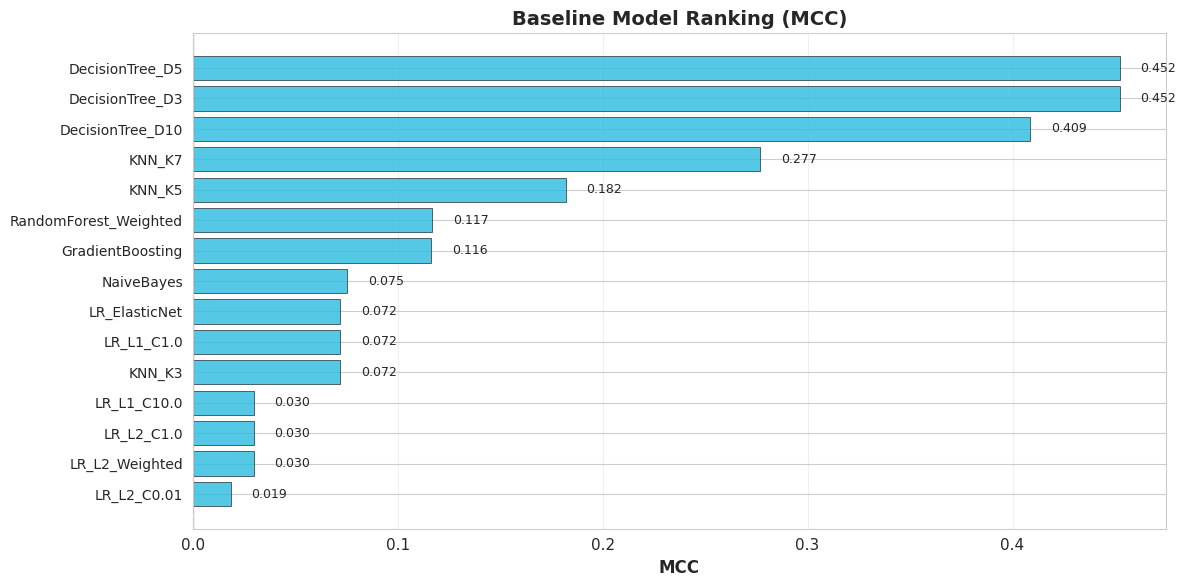

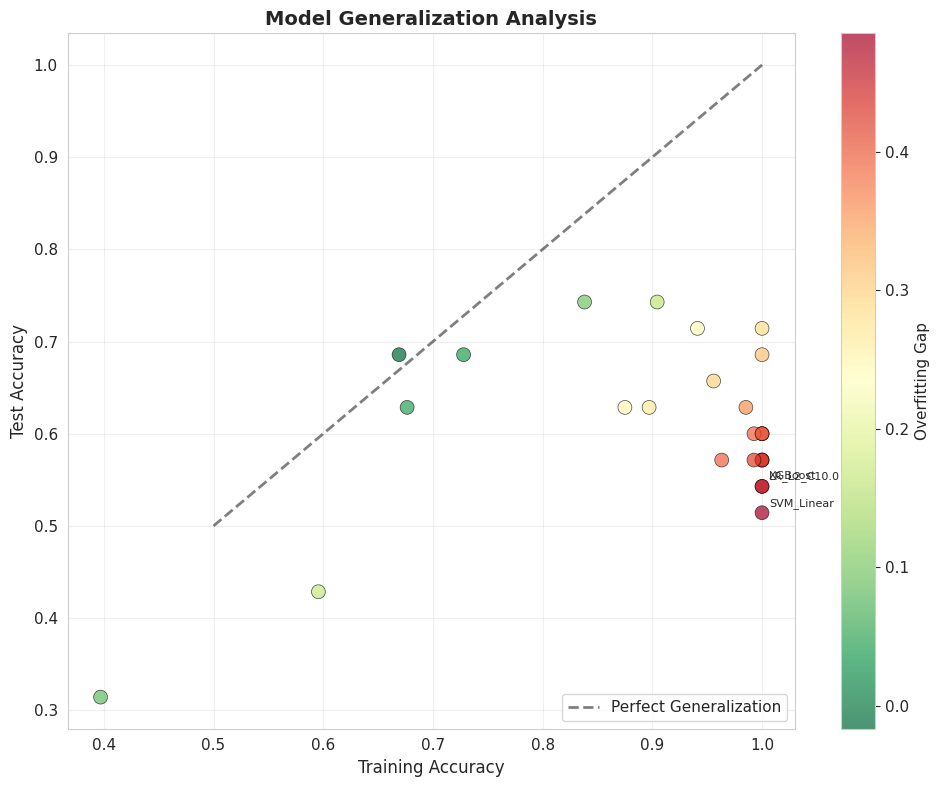


📊 Plotting Baseline Results (With SMOTE)...


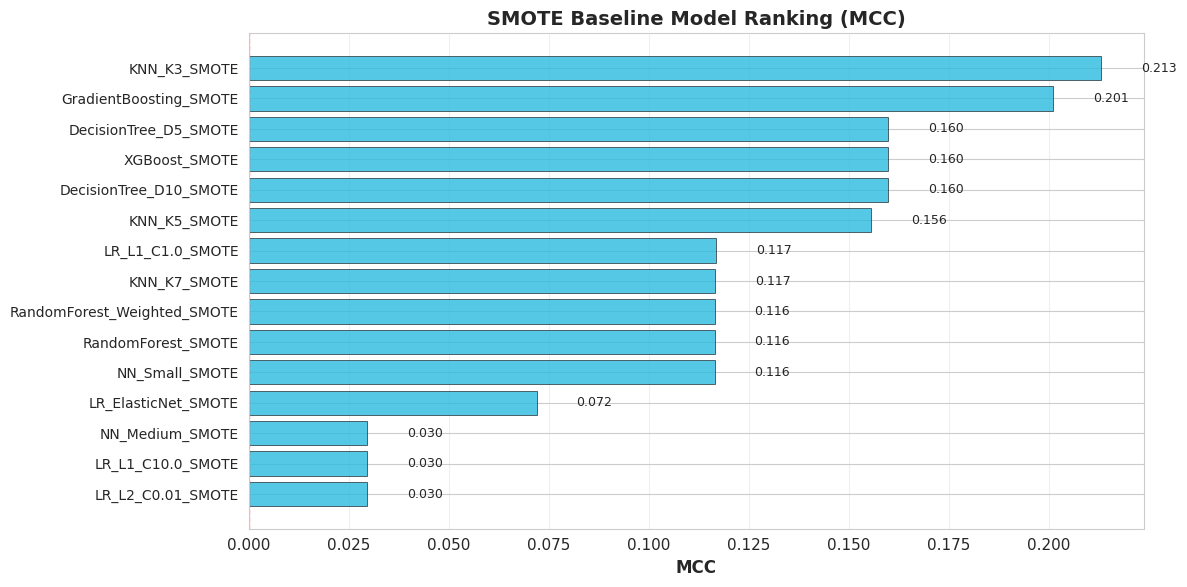

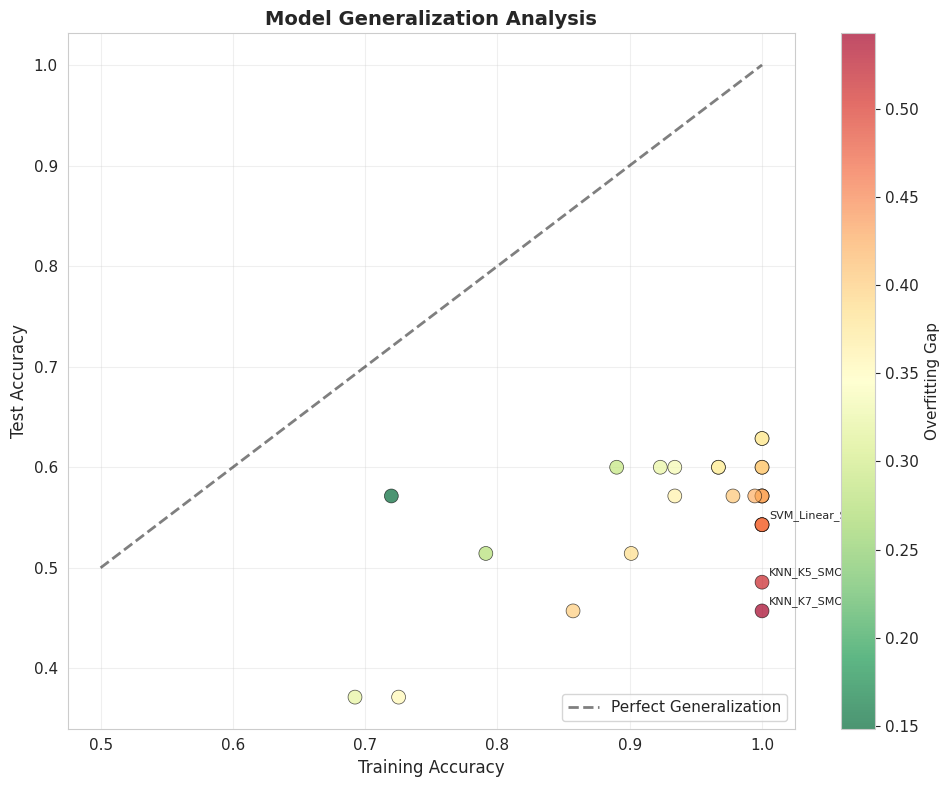


📊 Plotting Nested Cross-Validation Results...


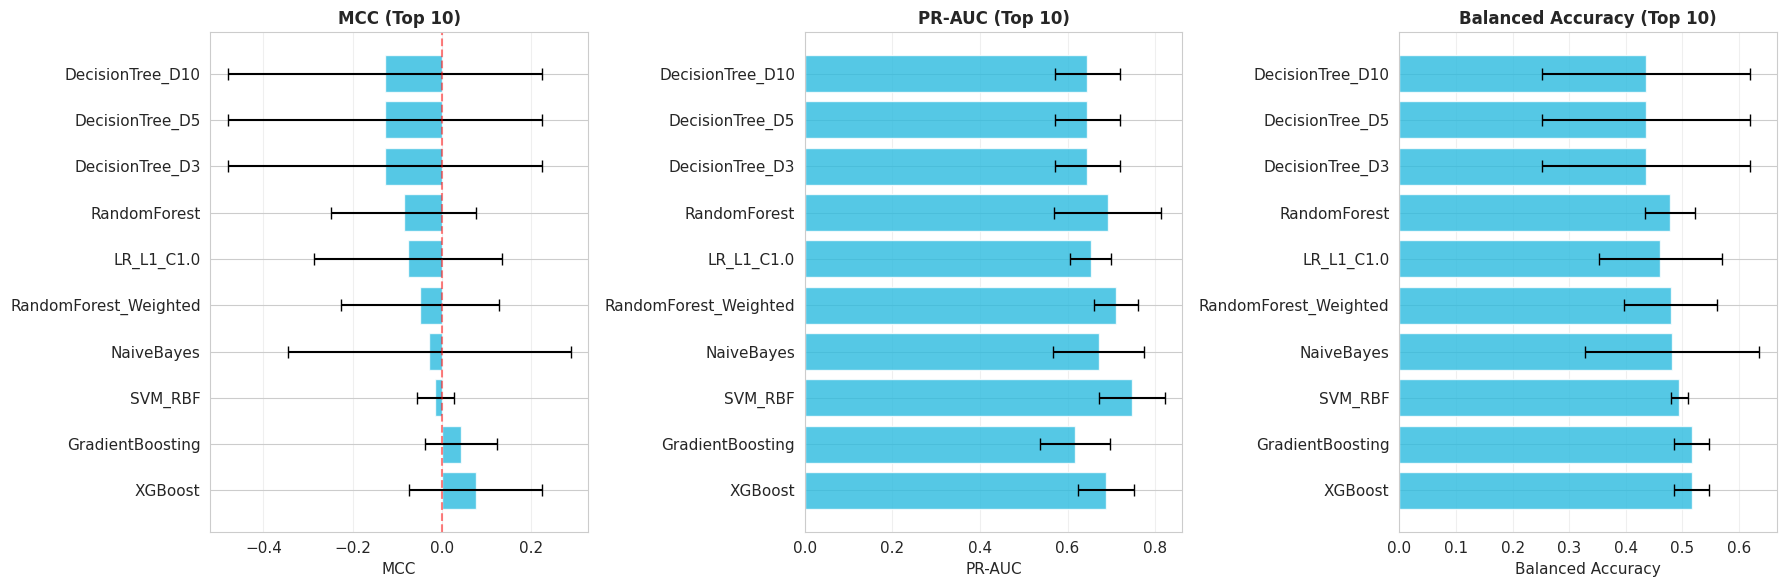


✓ All visualizations saved to outputs
✓ Saved: outputs/baseline_results.csv
✓ Saved: outputs/baseline_smote_results.csv
✓ Saved: outputs/nested_cv_results.csv


In [22]:
# Summary and visualization
pipeline.print_summary()
pipeline.generate_visualizations()
pipeline.export_results()

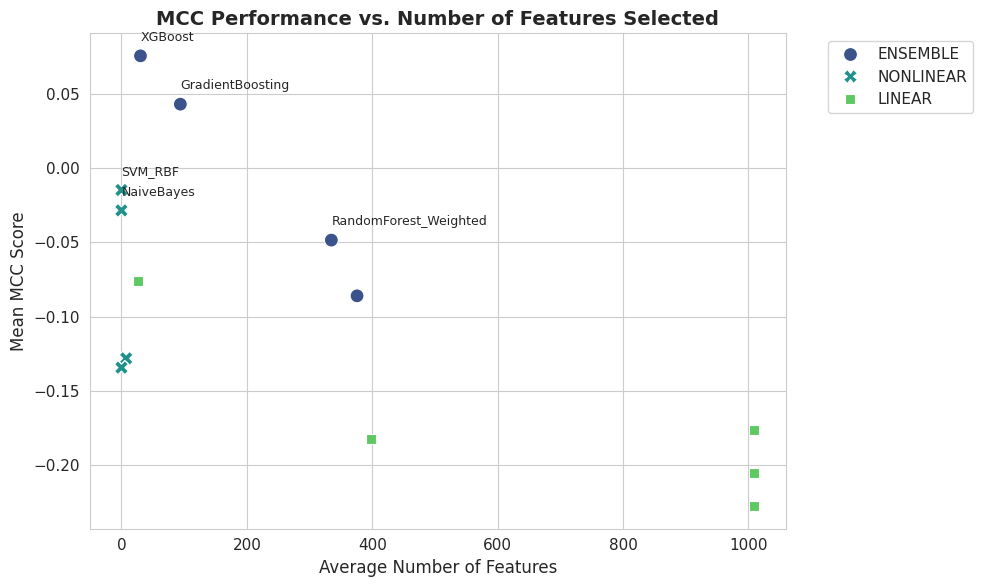

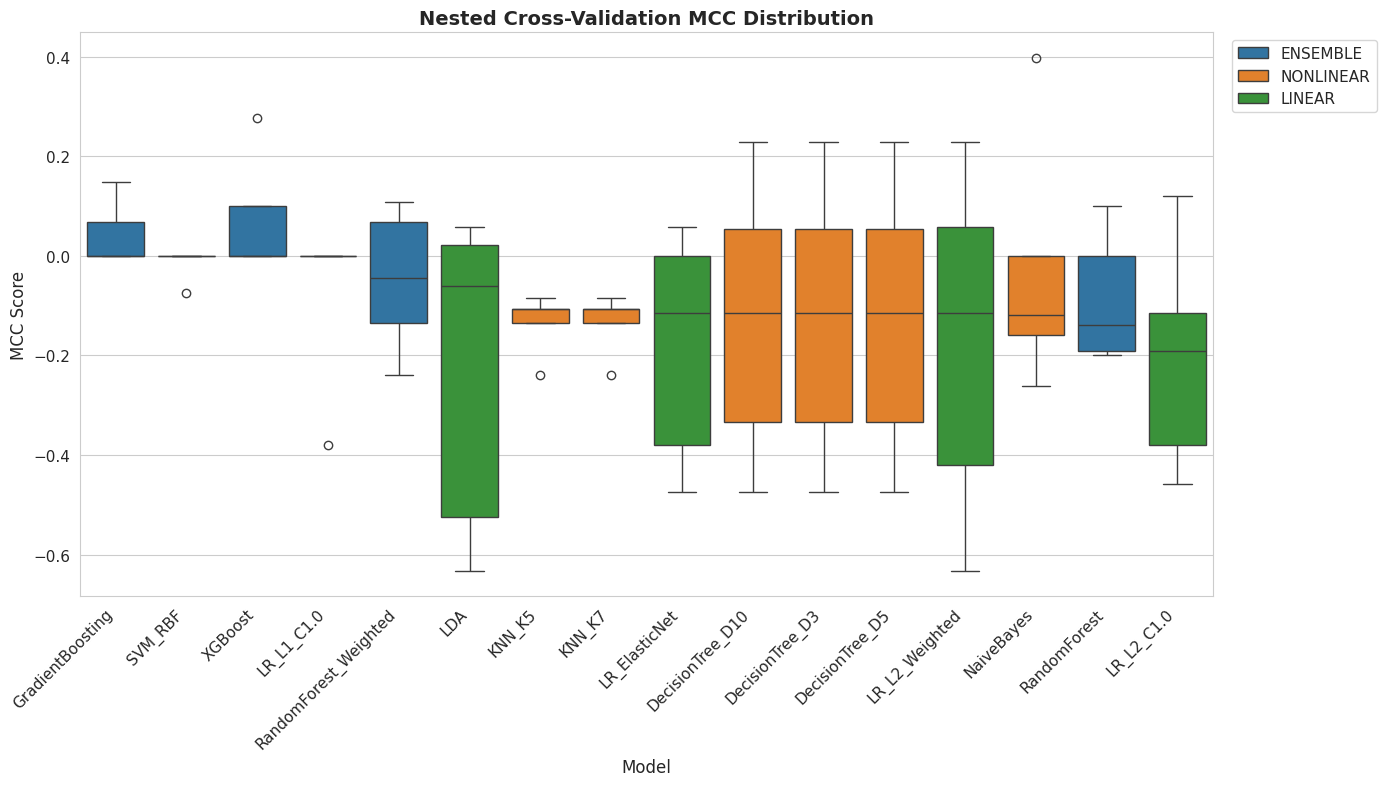

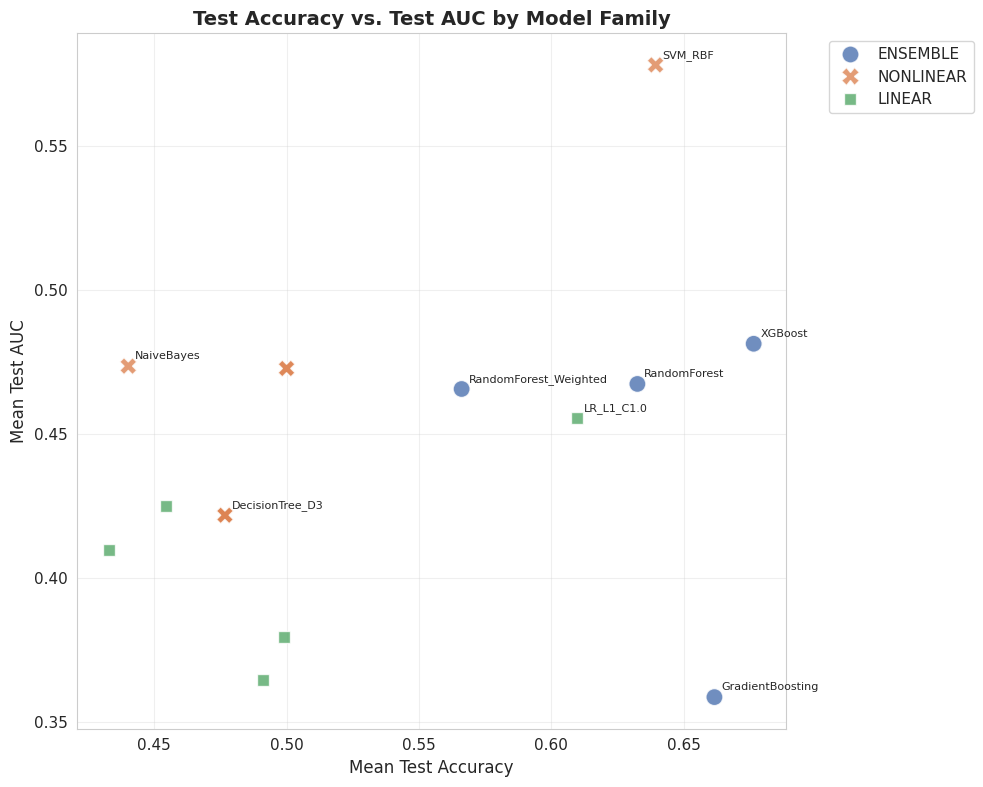

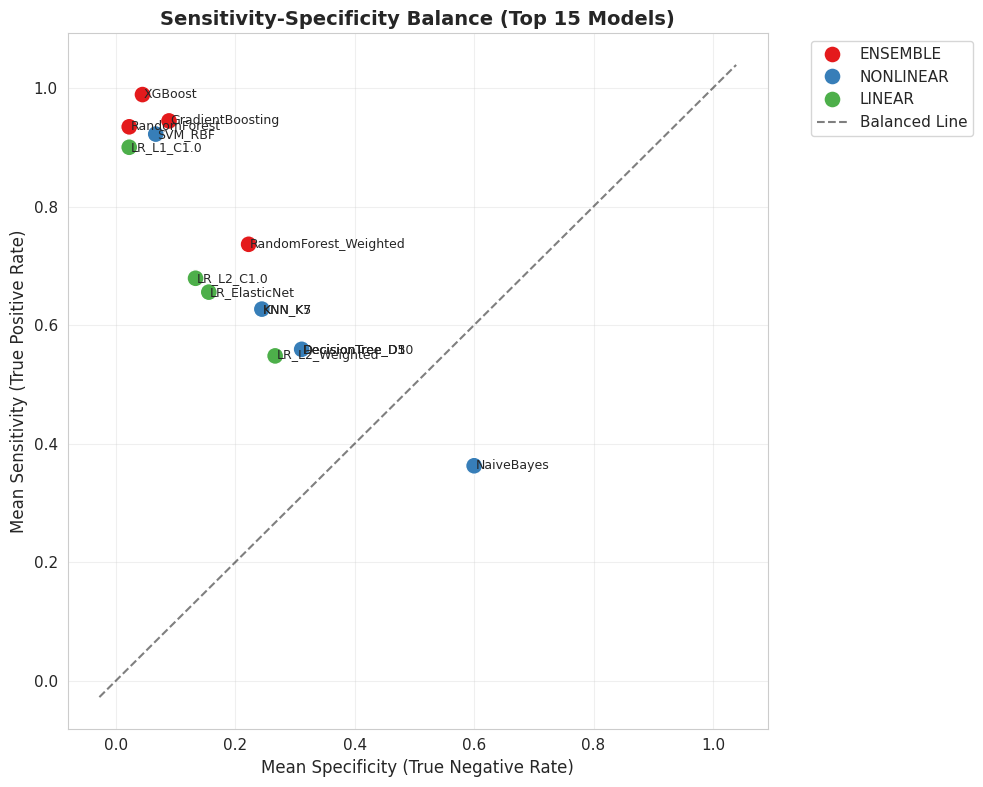

In [23]:
if 'nested_cv' in pipeline.results:
    results_df = pipeline.results['nested_cv']
    
    # Set style
    sns.set_style("whitegrid")
    
    # -------------------------------------------------------------------------
    # 1. MCC Performance vs Number of Features (Scatter Plot)
    # -------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    
    if 'mean_n_features' in results_df.columns:
        sns.scatterplot(
            data=results_df,
            x='mean_n_features',
            y='mean_mcc',
            hue='model_type',
            style='model_type',
            s=100,
            palette='viridis'
        )
        
        # Add labels for top points
        top_points = results_df.nlargest(5, 'mean_mcc')
        for _, row in top_points.iterrows():
            plt.text(
                row['mean_n_features'], 
                row['mean_mcc']+0.01, 
                row['model'], 
                fontsize=9
            )
            
        plt.title('MCC Performance vs. Number of Features Selected', fontsize=14, fontweight='bold')
        plt.xlabel('Average Number of Features', fontsize=12)
        plt.ylabel('Mean MCC Score', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Information about number of features not found in results.")

    # -------------------------------------------------------------------------
    # 2. Nested Cross-Validation Results Distribution (Box Plot)
    # -------------------------------------------------------------------------
    # Extract raw scores from 'all_scores' dictionary column
    cv_scores_data = []
    
    for _, row in results_df.iterrows():
        model_name = row['model']
        model_type = row['model_type']
        
        # Check if all_scores exists and has MCC data
        if 'all_scores' in row and isinstance(row['all_scores'], dict):
            mcc_scores = row['all_scores'].get('mcc', [])
            for score in mcc_scores:
                cv_scores_data.append({
                    'Model': model_name,
                    'MCC': score,
                    'Type': model_type
                })
    
    if cv_scores_data:
        cv_scores_df = pd.DataFrame(cv_scores_data)
        
        # Sort models by median MCC
        order = cv_scores_df.groupby('Model')['MCC'].median().sort_values(ascending=False).index
        
        plt.figure(figsize=(14, 8))
        sns.boxplot(
            data=cv_scores_df,
            x='Model',
            y='MCC',
            hue='Type',
            order=order,
            dodge=False
        )
        plt.xticks(rotation=45, ha='right')
        plt.title('Nested Cross-Validation MCC Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Model', fontsize=12)
        plt.ylabel('MCC Score', fontsize=12)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------------------
    # 3. Test Accuracy vs Test AUC of Model Families
    # -------------------------------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=results_df,
        x='mean_accuracy',
        y='mean_auc',
        hue='model_type',
        style='model_type',
        s=150,
        alpha=0.8,
        palette='deep'
    )
    
    # Annotate top models
    for _, row in results_df.nlargest(8, 'mean_mcc').iterrows():
        plt.annotate(
            row['model'], 
            (row['mean_accuracy'], row['mean_auc']),
            xytext=(5, 5), 
            textcoords='offset points',
            fontsize=8
        )
        
    plt.title('Test Accuracy vs. Test AUC by Model Family', fontsize=14, fontweight='bold')
    plt.xlabel('Mean Test Accuracy', fontsize=12)
    plt.ylabel('Mean Test AUC', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------------------------
    # 4. Sensitivity-Specificity Balance (Top 15 Models)
    # -------------------------------------------------------------------------
    top_15_df = results_df.nlargest(15, 'mean_mcc')
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    sns.scatterplot(
        data=top_15_df,
        x='mean_specificity',
        y='mean_sensitivity',
        hue='model_type',
        s=150,
        palette='Set1'
    )
    
    # Add labels
    for _, row in top_15_df.iterrows():
        plt.text(
            row['mean_specificity']+0.002, 
            row['mean_sensitivity'], 
            row['model'], 
            fontsize=9,
            va='center'
        )
        
    # Add diagonal balance line
    lims = [
        min(top_15_df['mean_specificity'].min(), top_15_df['mean_sensitivity'].min()) - 0.05,
        max(top_15_df['mean_specificity'].max(), top_15_df['mean_sensitivity'].max()) + 0.05
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='Balanced Line')
    
    plt.title('Sensitivity-Specificity Balance (Top 15 Models)', fontsize=14, fontweight='bold')
    plt.xlabel('Mean Specificity (True Negative Rate)', fontsize=12)
    plt.ylabel('Mean Sensitivity (True Positive Rate)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("No Nested CV results found. Please run the pipeline first.")

In [24]:
# Statistical comparison
if 'nested_cv' in pipeline.results and len(pipeline.results['nested_cv']) >= 2:
    print("\n" + "=" * 80)
    print("STATISTICAL COMPARISON")
    print("=" * 80)
    
    df = pipeline.results['nested_cv']
    
    for i in range(min(3, len(df))):
        for j in range(i+1, min(5, len(df))):
            m1, m2 = df.iloc[i], df.iloc[j]
            
            ci_overlap = (
                m1['ci_mcc_lower'] <= m2['ci_mcc_upper'] and
                m2['ci_mcc_lower'] <= m1['ci_mcc_upper']
            )
            
            print(f"\n{m1['model']} vs {m2['model']}:")
            print(f"  MCC: {m1['mean_mcc']:.3f} vs {m2['mean_mcc']:.3f}")
            print(f"  Difference: {abs(m1['mean_mcc'] - m2['mean_mcc']):.4f}")
            print(f"  Significant: {'No' if ci_overlap else 'Yes'}")


STATISTICAL COMPARISON

XGBoost vs GradientBoosting:
  MCC: 0.075 vs 0.043
  Difference: 0.0325
  Significant: No

XGBoost vs SVM_RBF:
  MCC: 0.075 vs -0.015
  Difference: 0.0902
  Significant: No

XGBoost vs NaiveBayes:
  MCC: 0.075 vs -0.028
  Difference: 0.1039
  Significant: No

XGBoost vs RandomForest_Weighted:
  MCC: 0.075 vs -0.048
  Difference: 0.1239
  Significant: No

GradientBoosting vs SVM_RBF:
  MCC: 0.043 vs -0.015
  Difference: 0.0577
  Significant: No

GradientBoosting vs NaiveBayes:
  MCC: 0.043 vs -0.028
  Difference: 0.0714
  Significant: No

GradientBoosting vs RandomForest_Weighted:
  MCC: 0.043 vs -0.048
  Difference: 0.0914
  Significant: No

SVM_RBF vs NaiveBayes:
  MCC: -0.015 vs -0.028
  Difference: 0.0137
  Significant: No

SVM_RBF vs RandomForest_Weighted:
  MCC: -0.015 vs -0.048
  Difference: 0.0337
  Significant: No


In [25]:
# Feature Selection Stability Analysis
if 'nested_cv' in pipeline.results:
    print("\n" + "=" * 80)
    print("FEATURE SELECTION STABILITY ANALYSIS")
    print("=" * 80)
    
    results_df = pipeline.results['nested_cv']
    
    # Filter for models that have feature selection info
    # We check if 'mean_n_features' column exists and has non-null values
    if 'mean_n_features' in results_df.columns:
        fs_models = results_df[results_df['mean_n_features'].notna()].copy()
        
        if not fs_models.empty:
            # Sort by stability (lower std_n_features is better)
            fs_models = fs_models.sort_values('std_n_features')
            
            print("\n1. NUMBER OF FEATURES STABILITY (Cross-Validation)")
            print("   (Lower std_dev indicates more consistent sparsity)")
            print("-" * 60)
            print(fs_models[['model', 'mean_n_features', 'std_n_features', 'mean_mcc']].to_string(index=False))
            
            # Display Most Stable Features for Top Models
            print("\n\n2. TOP STABLE FEATURES (for best performing models)")
            print("   (Features consistently selected/weighted high across folds)")
            print("-" * 60)
            
            top_models = fs_models.nlargest(3, 'mean_mcc')
            
            for _, row in top_models.iterrows():
                print(f"\nModel: {row['model']} (MCC: {row['mean_mcc']:.3f})")
                
                if 'feature_ranking' in row and isinstance(row['feature_ranking'], list) and row['feature_ranking']:
                    # feature_ranking is a list of dicts
                    ranking = pd.DataFrame(row['feature_ranking'])
                    if not ranking.empty:
                        print(ranking[['feature', 'mean_importance', 'std_importance', 'rank']].head(10).to_string(index=False))
                    else:
                        print("  No feature ranking available.")
                else:
                    print("  No feature importance data available.")
        else:
            print("No models with variable feature selection found.")
    else:
        print("Feature selection metrics (mean_n_features) not found in results.")


FEATURE SELECTION STABILITY ANALYSIS

1. NUMBER OF FEATURES STABILITY (Cross-Validation)
   (Lower std_dev indicates more consistent sparsity)
------------------------------------------------------------
                model  mean_n_features  std_n_features  mean_mcc
           NaiveBayes              0.0        0.000000 -0.028470
              SVM_RBF              0.0        0.000000 -0.014744
               KNN_K7              0.0        0.000000 -0.134194
               KNN_K5              0.0        0.000000 -0.134194
      DecisionTree_D5              7.6        1.854724 -0.127961
     DecisionTree_D10              7.6        1.854724 -0.127961
      DecisionTree_D3              7.6        1.854724 -0.127961
       LR_L2_Weighted           1009.2       12.639620 -0.175969
                  LDA           1009.2       12.639620 -0.227386
           LR_L2_C1.0           1009.2       12.639620 -0.204906
              XGBoost             30.4       26.777603  0.075470
           LR_L